In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

from textblob.sentiments import NaiveBayesAnalyzer

import pandas as pd
import sqlite3
from textblob import TextBlob

import seaborn as sns
sns.set(color_codes=True)

# encoding=utf8
import sys
reload(sys)
sys.setdefaultencoding('utf8')

import spacy
nlp = spacy.load('en')

import re

In [7]:
df = pd.read_csv('../pitchfork3.csv')

years = np.arange(1999, 2018)
df_new = df[df['new_album'] == 1]
df_reissue = df[df['new_album'] == 0]

In [8]:
df_spotify = pd.read_csv('spotify_with_rank.csv')

df_merged = df.merge(df_spotify, how='left', on=['artist', 'title'])

In [9]:
df_merged.shape

(20125, 98)

## How Good are the Good Albums?

When filtering for only albums that received a score of 8.0 or higher, I found that the mean score is decreasing year over year.

In [11]:
sns.set_style("whitegrid")
sns.set_style('ticks')

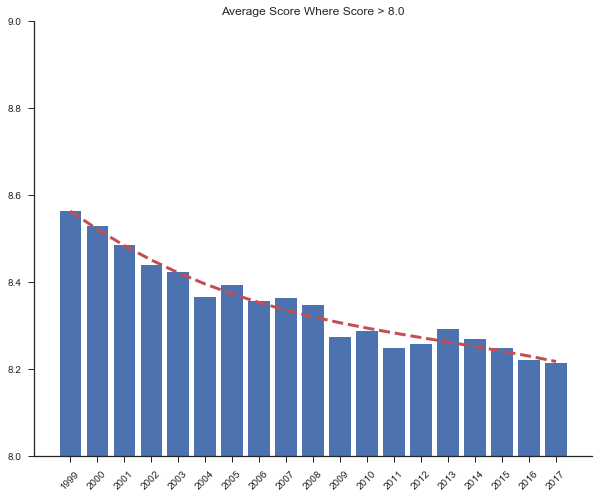

In [70]:
filtered_df = df[
                  (df['score'] >= 9)  & \
                  (df['new_album'] == 1) & (df['num_prev_reviews'] == 1) & (df['pub_year'] < 2010 )]
filtered_df

plt.figure(figsize=(10,8))

plt.title('Average Score Where Score > 8.0')

x = years
y = df_merged[(df_merged['new_album'] == 1) & 
              (df_merged['score'] >= 8.0 )].groupby('pub_year')['score'].mean()
z = np.polyfit(x, y, 3)
p = np.poly1d(z)
plt.plot(x,p(x),"r--", lw=3)
plt.bar(x, y)
plt.ylim(8, 9)
plt.xticks(years, rotation=45)
sns.despine()
plt.show()

Good albums are not as good as they used to be. Overall, Pitchfork has become more conservative in handing out scores above a 9.0 (as I explored in the EDA notebook).

### Is Pitchfork more comfortable giving extreme high scores when the artist has been reviewed before?

Before 2010, it didn't make much of a difference if the artist had been reviewed before. However, from 2011-2015 leading up to the Conde Nast acquisition, 8.0+ reviews from artists being reviewed for the first time had a significantly lower score than albums where the artist had been reviewed before.

After the acquisition, there was no significant difference.

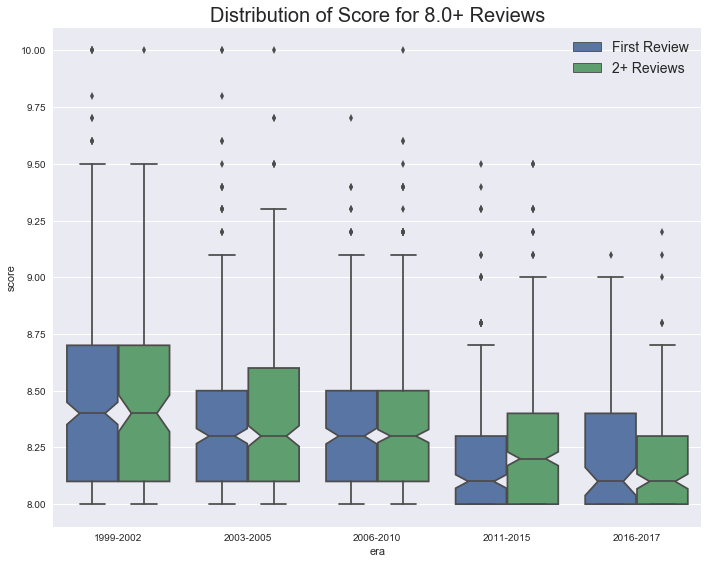

In [68]:
temp_df = df[(df['new_album'] == 1) & (df['score'] >= 8)]
temp_df['oft_reviewed'] = np.where(temp_df['num_prev_reviews'] > 1, "2+ Reviews", "First Review") 
plt.figure(figsize=(10,8))
plt.title('Distribution of Score for 8.0+ Reviews', fontsize=20)

sns.boxplot(x=temp_df['era'][::-1], y=temp_df['score'], 
            data=temp_df[['score', 'era']], 
            hue=temp_df['oft_reviewed'][::-1],
           notch=True)
plt.legend(fontsize=14, loc=1)
plt.tight_layout()

Let's take a look at the outliers. What do we know about the artists who received a 9.0+ for their first album reviewed? I'm filtering out albums that did not receive Best New Music -- before that label was introduced, Pitchfork gave out 9.0+ reviews more frequently, as they didn't have a better way to signal to readers that the album being reviewed is essential.

In [32]:
df_9 = df[(df['score'] >= 9)  & (df['best_new_music']==1) & (df['new_album'] == 1) & (df['num_prev_reviews'] ==1)][['artist', 'title', 'score', 'pub_year']]
df_9

,artist,title,score,pub_year
2070,anohni,hopelessness,9.0,2016
3151,jamie xx,in colour,9.3,2015
3647,"dangelo, the vanguard",black messiah,9.4,2014
5468,disclosure,settle,9.1,2013
8883,big boi,sir lucious left foot: the son of chico dusty,9.2,2010
9798,girls,album,9.1,2009
11650,hercules and love affair,hercules and love affair,9.1,2008
12820,the field,from here we go sublime,9.0,2007
14001,ghostface killah,fishscale,9.0,2006
14917,clap your hands say yeah,clap your hands say yeah,9.0,2005


## Several of the are artists who are associated with other more popular acts:

- ANOHNI is the leader of Antony and the Johnsons, who has been reviewed by Pitchfork 9 times previous
- Jamie XX is from The XX, who was well established and reviewed previous to In Colour's release
- D'angelo / The Vanguard's previous album was billed as simply 'D'angelo'
- Big Boi is better known for being part of Outkast, Ghostface Killah is better known for his work with the Wu-Tang Clan
- Brian Wilson and Loretta Lynn both had long careers before their first Pitchfork review.

In [33]:
filter_artists = ['anohni', 'jamie xx', 'dangelo, the vanguard', 'big boi', 'brian wilson', 'loretta lynn', 'ghostface killah']

After filtering for artists that were obviously not new, here's what we have:

In [34]:
df_9[~df_9['artist'].isin(filter_artists)]

,artist,title,score,pub_year
2070,anohni,hopelessness,9.0,2016
3151,jamie xx,in colour,9.3,2015
3647,"dangelo, the vanguard",black messiah,9.4,2014
8883,big boi,sir lucious left foot: the son of chico dusty,9.2,2010
14001,ghostface killah,fishscale,9.0,2006
15761,brian wilson,smile,9.0,2004
16238,loretta lynn,van lear rose,9.3,2004


Pitchfork gambled on a lot of artists in 2003 and 2004, and several of these artists went on to be very successful -- notably Broken Social Scene, M83, Arcade Fire, and Disclosure. But Pitchfork *does not gamble on new artists any more*.

In [64]:
sns.set_style('ticks')

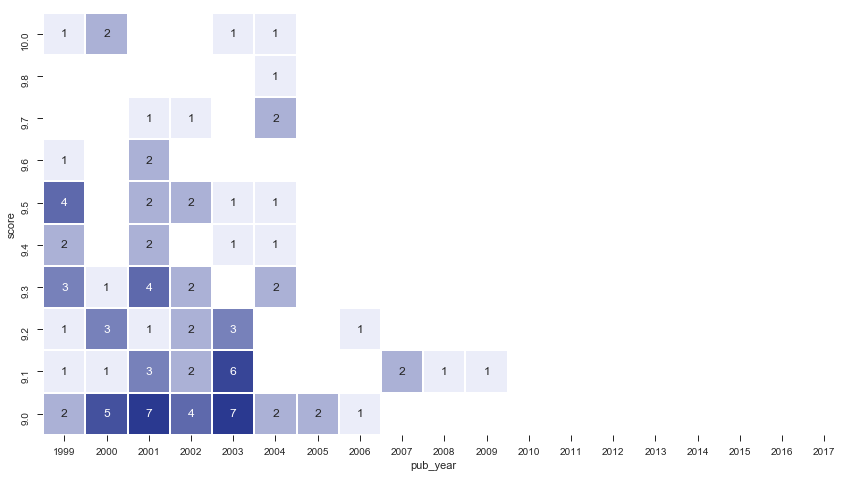

In [66]:
# x: year
# y: score 8.0 - 10.0
# z: count of first/second releases with that score

filtered_df = df[ (~df['artist'].isin(filter_artists)) & \
                  (df['score'] >= 9)  & \
                  (df['new_album'] == 1)  \
                   & (df['num_prev_reviews'] == 1) \
                    ]
temp_df = pd.DataFrame(filtered_df.groupby(['pub_year', 'score'])['reviewid'].count()).reset_index()
heatmap_df = temp_df.pivot(index='score', columns='pub_year', values='reviewid')

plt.figure(figsize=(14,9))
# plt.title("Artists Pitchfork has Reviewed More than Once")
# plt.suptitle('Count of Albums Receiving Scores +9.0')
plt.xlabel('Year')
plt.ylabel('Score')
sns.heatmap(heatmap_df[::-1], 
            annot=(heatmap_df[::-1]).round(3), 
            norm=LogNorm(vmin=0, vmax=1), 
            fmt='g', 
            linewidths=1,
            cbar=False,
            square=True,
            xticklabels=range(1999,2018),
            cmap=sns.light_palette('#2a3990', n_colors=16)
           )
plt.savefig("firsttimeartist9")

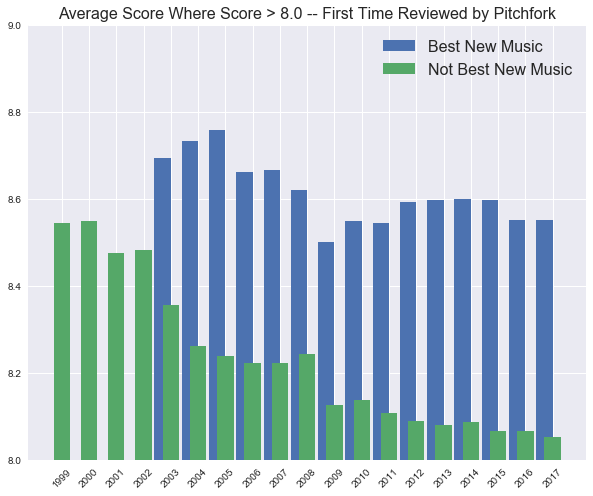

In [34]:
plt.figure(figsize=(10,8))

plt.title('Average Score Where Score > 8.0 -- First Time Reviewed by Pitchfork', fontsize=16)

x = years[4:19]
y = df_merged[(df_merged['best_new_music'] == 1) & (df_merged['new_album'] == 1) & 
              (df_merged['score'] >= 8.0) &
              (df_merged['order_of_release'] >= 0)].groupby('pub_year')['score'].mean()
y_1 = df_merged[(df_merged['best_new_music'] == 0) & (df_merged['new_album'] == 1) & 
              (df_merged['score'] >= 8.0) &
              (df_merged['order_of_release'] >= 0)].groupby('pub_year')['score'].mean()
# z = np.polyfit(x, y, 1)
# p = np.poly1d(z)
# plt.plot(x,p(x),"r--")
plt.bar(x-.3, y, width=.6, label="Best New Music")
plt.bar(range(1999,2018), y_1, width=.6, label="Not Best New Music")
plt.legend(fontsize=16)
plt.xticks(years, rotation=45)
plt.ylim(8,9)
plt.show()